This IPYNB file is just a helper to work on the crosssections.py
Feel free to change anything you want. Everything is saved in the
crosssections.py.

In [232]:
import logging
logging.getLogger('trimesh').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('matplotlib').setLevel(logging.CRITICAL)
import numpy as np
import matplotlib.pyplot as plt
import pvtrace as pv

world = pv.Node(
    name="world (air)",
    geometry=pv.Sphere(
        radius=10.0,
        material=pv.Material(refractive_index=1.0,

                          )
    )
)

sphere = pv.Node(
    name="sphere1 (glass)",
    geometry=pv.Sphere(
        radius=0.8,
        material=pv.Material(
            refractive_index=1.0,
            components=[
                pv.Scatterer(coefficient=4.1)
            ]

        ),
    ),
    parent=world
)
sphere2 = pv.Node(
    name="sphere2 (glass)",
    geometry=pv.Sphere(
        radius=0.5,
        material=pv.Material(
            refractive_index=1.0,

        ),
    ),
    parent=world
)
sphere2.translate((0, 0.2, 0.2))
# ray = Ray(
#     position=(-1.0, 0.0, 0.9),
#     direction=(1.0, 0.0, 0.0),
#     wavelength=555.0
# )
import functools

light = pv.Node(
    name="Light (555nm)",
    light=pv.Light(direction=functools.partial(pv.cone, np.pi / 32)),
    parent=world
)
light.translate((0.0, 0.0, 3))
light.rotate(np.pi, [1, 0, 0])
scene = pv.Scene(world)

In [233]:
def scene_render_and_positions(scene, random_seed=0, open_browser=True, show_3d=True):
    """
    The main purpose of this function is to propagate rays and return all there trajectories, as
    arrays of all dots they have "visited".
    Function also renders 3D picture if show_3d=True.
    :param scene: pv.Scene(world) with all Nodes (objects and light sources)
    :param random_seed: random seed for the ray-tracing
    :param open_browser: show in the browser
    :param show_3d: 3d rendering
    :return: positions of all the rays
    """
    positions = []
    np.random.seed(random_seed)
    vis = pv.MeshcatRenderer(wireframe=True, open_browser=open_browser)
    if show_3d:
        vis.render(scene)
    for ray in scene.emit(30):
        steps = pv.photon_tracer.follow(scene, ray)
        path, decisions = zip(*steps)
        positions_ray = []
        for ray in path:
            positions_ray.append(ray.position)
        positions.append(np.array(positions_ray))
        if show_3d:
            vis.add_ray_path(path)
    return np.array(positions)
positions = scene_render_and_positions(scene)
# print(positions)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


<ipython-input-233-2cc228669c9b>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(positions)


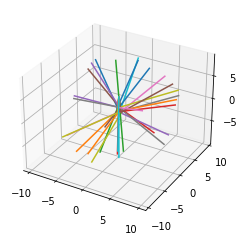

In [234]:
ax = plt.figure().add_subplot(projection='3d')
for position in positions:
    ax.plot(position[:, 0], position[:, 1], position[:, 2])
# ax.legend()
plt.show()

In [235]:
def dot_on_segment(dot, dot1, dot2):
    """
    Function checks if the dot is on the line in between dot1 and dot2. dot must be on
    the line.
    :param dot: (x, y, z) the do must be on the line (it's from the crossing_plane_line())
    :param dot1: (x1, y1, z1)
    :param dot2: (x2, y2, z2)
    :return: True if the line is on the segment, otherwise False
    """
    if dot is None:
        return False
    for x, x1, x2 in zip(dot, dot1, dot2):
        if x2 >= x1:
            if x1 <= x <= x2:
                pass
            else:
                return False
        else:
            if x2 <= x <= x1:
                pass
            else:
                return False
    return True


def crossing_plane_line(dot1, dot2, plane = (0, 0, 1, 0), check_segment=True):
    """
    Function finds the crossing of the line (in between dot1 and dot2) and the plane.
    Line : (x-x1)/(x2-x1) = (y-y1)/(y2-y1) = (z-z1)/(z2-z1)

    Plane: Ax + By + Cz + D = 0
    |x-x1  y-y1  z-z1 |
    |x2-x1 y2-y1 z2-z1| = 0
    |x3-x1 y3-y1 z3-z1|
    Example:
    (-5, -5, 0), (-5, 5, 0), (5, 5, 0)
    z = 0
    (https://ru.onlinemschool.com/math/assistance/cartesian_coordinate/plane/)

    Crossing: https://matworld.ru/analytic-geometry/tochka-peresechenija-prjamoj-i-ploskosti.php
    (look at equations, ignore the text)
    :param dot1: (x1, y1, z1)
    :param dot2: (x2, y2, z2)
    :param plane: (A, B, C, D) where Ax + By + Cz + D = 0
    :param check_segment: if True, checking if the don is on the segment in between dot1 and dot2
    :return: dot: (x, y ,z) or None if there is no crossing
    """
    x1, y1, z1 = dot1
    x2, y2, z2 = dot2
    m1 = x2 - x1
    p1 = y2 - y1
    l1 = z2 - z1
    # z = D plane
    A, B, C, D = plane
    matrix = [[p1, -m1, 0], [0, l1, -p1], [A, B, C]]
    vector = [[p1 * x1 - m1 * y1], [l1 * y1 - p1 * z1], [-D]]
    try:
        dot_cross = np.linalg.solve(matrix, vector)
        if not np.allclose(np.dot(matrix, dot_cross), vector):
            print(f'WRONG CROSSINGS')
    except np.linalg.LinAlgError:
        dot_cross = None
    dot_ans = np.array([dot_cross[0,0], dot_cross[1,0], dot_cross[2,0]])
    if check_segment:
        check = dot_on_segment(dot_cross, dot1, dot2)
        if check:
            return dot_ans
        else:
            return None

    return dot_ans


# dot1 = [0, 1, 1]
# dot2 = [-1, -3, -2]
# dot_cross = crossing_plane_line(dot1, dot2, plane = (0, 0, 1, 0))

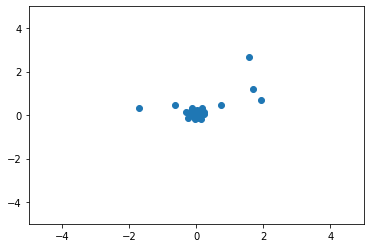

In [236]:
def crossings_plane_rays(positions, plane):
    """
    Function return all crossings of rays with the plane.
    :param positions: Array [[[x1_r1, x2_r1, x3_r1], [x1_r1, x2_r1, x3_r1],...],
                            [[x1_r2, x2_r2, x3_r2], [x1_r2, x2_r2, x3_r2],...],...]
                            r1 - ray1, r2 - ray2.
                            Arrays from the photon_tracer.follow(scene, ray)
    :param plane: (A, B, C, D) where Ax + By + Cz + D = 0
    :return: [[x1, x2, x3], [x1, x2, x3],...] - all crossings
    """
    crossings = []
    for dots in positions:
        dot1 = dots[0]
        for dot2 in dots[1:]:
            dot_cross = crossing_plane_line(dot1, dot2, plane = plane)
            # print(dot_cross)
            if dot_cross is not None:
                crossings.append(dot_cross)
            dot1 = dot2
    return np.array(crossings)


plane = (0, 0, 1, -0.3)
crossings = crossings_plane_rays(positions, plane)
plt.scatter(crossings[:, 0], crossings[:, 1])
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

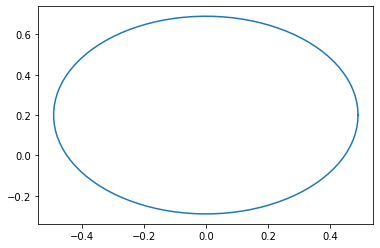

In [237]:
circle_res = 100
def crossing_plane_sphere(location, radius, plane, circle_res = 100):
    """
    This function return the circle of the plane with sphere crossing.
    For 3 different cross-section we are just renaming the axis.
    Parametric equation of the sphere is used. (check wiki: Sphere)
    :param location: (x0, y0, z0) center of the sphere
    :param radius: radius of the sphere
    :param plane: (A, B, C, D) where Ax + By + Cz + D = 0
    :param circle_res: the number of dots for the circle
    :return: x_array, y_array, if not crossing: None, None
    """
    if plane[:3] == (1, 0, 0):  # yz-cross-section
        y0, z0, x0 = location
    elif plane[:3] == (0, 1, 0):  # xz-cross-section
        z0, x0, y0 = location
    elif plane[:3] == (0, 0, 1):  # xy-cross-section
        x0, y0, z0 = location
    else:
        print(f'This cross-section is not implemented. Use XY, XZ, or YZ for now')
        return None, None
    z = -plane[3]
    if abs((z - z0) / radius) > 1:
        return None, None
    theta = np.arccos((z - z0) / radius)
    phi = np.linspace(0, 2 * np.pi, circle_res)
    x = x0 + radius * np.sin(theta) * np.cos(phi)
    y = y0 + radius * np.sin(theta) * np.sin(phi)
    return x, y

plane = (0, 0, 1, -0.3)

location = scene.root.leaves[1].location
radius = scene.root.leaves[1].geometry.radius

x, y = crossing_plane_sphere(location, radius, plane)
if x is not None:
    plt.plot(x, y)
    plt.show()

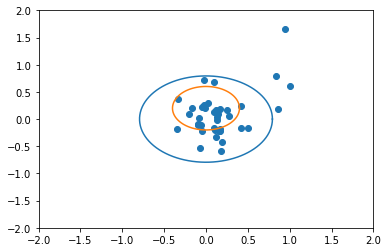

In [238]:
# ax = plt.figure()
def plot_scene_2D(scene, plane):
    """
    Plotting the cross-section of the scene.
    :param scene: pv scene
    :param plane: (A, B, C, D) where Ax + By + Cz + D = 0 determines the cross-section
    :return: None (but it plot lines, so you need to plt.show() after)
    """
    for node in scene.root.leaves:
        if isinstance(node.geometry, pv.Sphere):
            location = node.location
            radius = node.geometry.radius
            x, y = crossing_plane_sphere(location, radius, plane)
            if x is not None:
                plt.plot(x, y)
    # if ax is None:
    #     plt.show()
plane = (0, 0, 1, 0.1)

crossings = crossings_plane_rays(positions, plane)
plt.scatter(crossings[:, 0], crossings[:, 1])
plot_scene_2D(scene, plane)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()
